In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [2]:
def plot_autocor(name, df):
    plt.figure(figsize=(16, 4))
    timeLags = np.arange(1, 100 * 24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name);
    plt.ylabel('autocorr');
    plt.xlabel('time lags')
    plt.show()


In [3]:
mkts = pd.read_excel("interview_dataset_excel_v2.xlsx", index_col='Date',
                     usecols=['Date','US Equity', 'UK Equity', 'Japan Equity', 'Germany Equity',
                              'Canada Equity', 'US Bond', 'UK Bond', 'Japan Bond', 'Germany Bond',
                              'Canada Bond', 'EM Equity']).dropna(axis=0)

In [4]:
train_date = int(len(mkts)*0.7)
train_ret, test_ret = mkts.iloc[:train_date].pct_change(1).dropna(axis=0), mkts.iloc[train_date:].pct_change(1).dropna(axis=0)

In [26]:
mkts.iloc[train_date]

US Equity         2121.5211
UK Equity         2768.4412
Japan Equity       552.5147
Germany Equity     142.2568
Canada Equity     2083.7637
US Bond           2298.1800
UK Bond           1027.6150
Japan Bond         366.0660
Germany Bond       594.5590
Canada Bond        979.3640
EM Equity         1370.7119
Name: 2012-05-23 00:00:00, dtype: float64

BEST ORDER 3 BEST AIC: -115.76223844973231


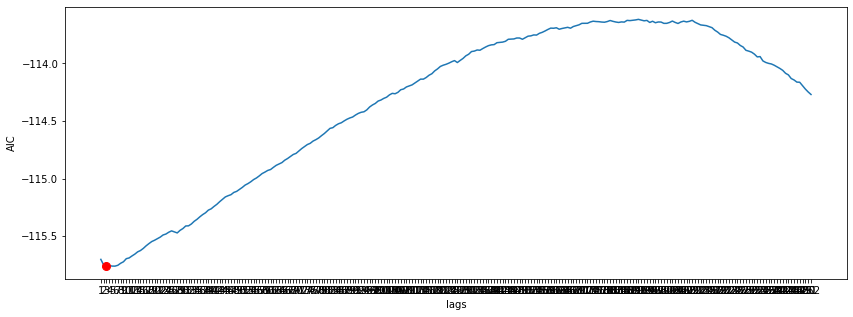

In [5]:
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1, 253):
    model = VAR(endog=train_ret.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER', best_order, 'BEST AIC:', best_aic)
### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,253))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [16]:
## fit VAR model with Order 3
var = VAR(endog=train_ret)
var_result = var.fit(maxlags=best_order)
var_result.aic

/Users/kingf.wong/.conda/envs/FinanceML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-115.76223844973231

In [143]:
train_pred_var = var_result.forecast(train_ret.iloc[:3].values, steps=1)
train_pred_var

array([[ 1.e-03,  4.e-03, -1.e-04,  4.e-03,  2.e-03,  2.e-05, -3.e-04,
        -3.e-04,  2.e-04,  2.e-04,  4.e-04]])

In [160]:
train_pred_var= pd.DataFrame(columns=train_ret.columns)
for i in range(3, len(train_ret)):
    train_pred_var.loc[i-3] = var_result.forecast(train_ret.iloc[i-3:i].values, steps=1)[0] ## rolling

    
train_pred_var.index = train_ret.iloc[3:].index
    

In [161]:
## get VAR prediction to feeed in neural network 
test_pred_var= pd.DataFrame(columns=test_ret.columns)
for i in range(3, len(test_ret)):
    test_pred_var.loc[i-3] = var_result.forecast(test_ret.iloc[i-3:i].values, steps=1)[0] ## rolling

    
test_pred_var.index = test_ret.iloc[3:].index

In [155]:
for mkt_col in train_ret.columns:
    # print(train_pred_var.loc['2012-01-01':'2012-01-31'][mkt_col])
    plt.plot(train_pred_var.loc['2012-01-01':'2012-01-31'][mkt_col], c='b', label='VAR Pred')
    plt.plot(train_ret.loc['2012-01-01':'2012-01-31'][mkt_col], c='r', label='True')
    plt.ylabel(mkt_col); plt.legend()
    plt.show()                      
                           

KeyError: 'US Equity'

In [163]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 30

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 18))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(9)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [167]:
train_pred_var= pd.DataFrame(columns=train_ret.columns)
for i in range(3, len(train_ret)):
    train_pred_var.loc[i-3] = var_result.forecast(train_ret.iloc[i-3:i].values, steps=1)[0] ## rolling

    
train_pred_var.index = train_ret.iloc[3:].index
    

In [168]:
## get VAR prediction to feeed in neural network 
test_pred_var= pd.DataFrame(columns=test_ret.columns)
for i in range(3, len(test_ret)):
    test_pred_var.loc[i-3] = var_result.forecast(test_ret.iloc[i-3:i].values, steps=1)[0] ## rolling

    
test_pred_var.index = test_ret.iloc[3:].index

In [169]:
## train, test and Xy split set


## not sure should we feed only returns or both returns and prices 
## trying just returns for now, feed both later

## only raw returns
y_train, X_train = train_ret.shift(1), train_ret.iloc[1:]
y_test, X_test = test_ret.shift(1), test_ret.iloc[1:]

## raw returns with VAR prediction
## back shift as that's the prediction of the current day from yesterday's
train_pred_var, test_pred_var = train_pred_var.add_prefix('var_').shift(-1), test_pred_var.add_prefix('var_').shift(-1)
comb_X_train, comb_X_test = X_train.merge(train_pred_var, left_index=True, right_index=True), X_test.merge(test_pred_var, left_index=True, right_index=True)

comb_X_train.dropna(inplace=True)
comb_X_test.dropna(inplace=True)

y_train = y_train.loc[comb_X_train.index]
y_test = y_test.loc[comb_X_test.index]

X_train = X_train.loc[comb_X_train.index]
X_test = X_test.loc[comb_X_test.index]






In [170]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(comb_X_train, y_train, length=seq_length, batch_size=32)

generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)
generator_test_var = TimeseriesGenerator(comb_X_test, y_test, length=seq_length, batch_size=32)

In [172]:
generator_train

In [179]:
def get_model(seq_length, n_features):
    opt = RMSprop(lr=0.002)

    inp = Input(shape=(seq_length, n_features))
    
    x = LSTM(64)(inp)
    
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)

    out = Dense(n_features//2)(x)

    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    

    return model

### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(),
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')

model_var = get_model(seq_length, len(comb_X_train.columns.tolist()))
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100,
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Epoch 1/100


ValueError: cannot copy sequence with size 30 to array axis with dimension 22